# Pedestrians recognition without using Deep Learning

## 1.Dependencies

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import glob
import matplotlib.image as mpimg

data_root = 'img1'
gt_path = './gt/gt.txt'

_W = 1280
_H = 960
_N = 684 # number of frames


## HOG function

In [2]:
def hog(im_path):
    hog = cv2.HOGDescriptor()
    im = cv2.imread(im_path)
    h = hog.compute(im)
    print(h)

## Display image

In [55]:
def disp_image(im):
    imgplot = plt.imshow(im)
    plt.show()

## Background substraction

In [249]:
def background_substraction(les_im_path, video_name=None, back_sub_folder="back_sub"):
    """
    Generate a video with background substraction
    :param les_im_path: list of string, images path
    :param video_name: string, default = None, if set, will save a video of the backgroud substraction to 'video_name'.avi
    :param back_sub_folder: string, default = 'back_sub', folder used to save background substracted images
    
    OUTPUT:
        back_sub/XXX.jpg : images of the background substraction
        
        if video_name != None:
            video_name.avi : video of the background substraction
    """
    
    # Create background frame
    fgbg = cv2.createBackgroundSubtractorMOG2()
    
    # Create output folder if doesn't already exist
    try:
        os.mkdir(back_sub_folder)
    except FileExistsError:
        pass
    
    if video_name is not None:
        # Get video size
        height,width,layers=cv2.imread(les_im_path[0]).shape

        # Create video object
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
        video = cv2.VideoWriter(video_name + '.avi', fourcc, fps=25, frameSize=(width,height), isColor=False)
    
    # Computing background
    for im_path in les_im_path:
        im = cv2.imread(im_path)
        fgmask = fgbg.apply(im)
        
        cv2.imwrite(back_sub_folder + '/' + im_path.split("/")[-1], fgmask)
        
        if video_name is not None:
            # Writing frame to video
            video.write(fgmask)
    
    if video_name is not None:
        # Close video
        video.release()

## Get human shaped contours

3.5


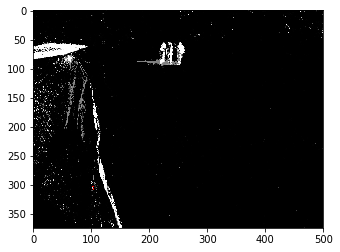

429.5


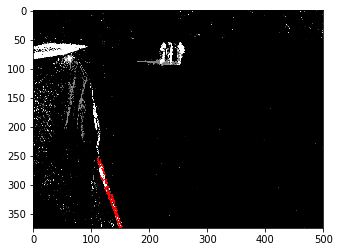

14.0


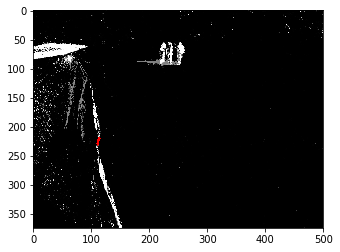

4.5


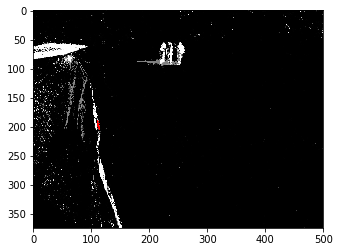

105.0


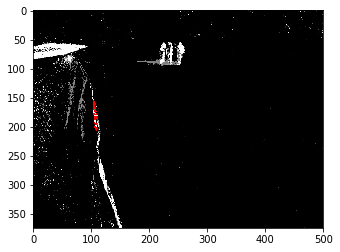

9.0


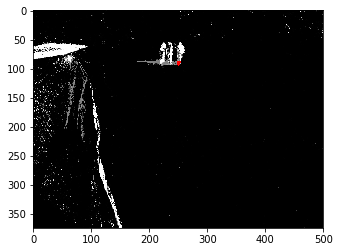

46.5


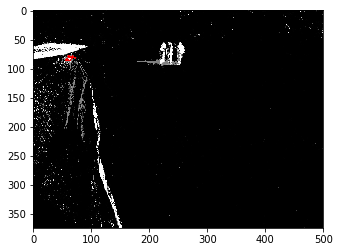

67.0


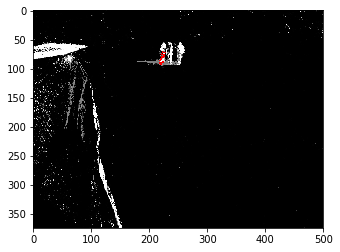

53.5


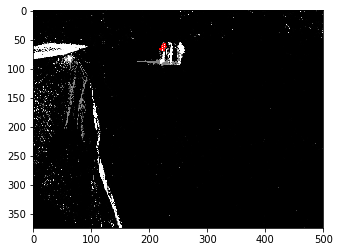

1346.5


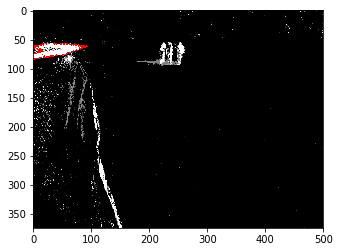

141.5


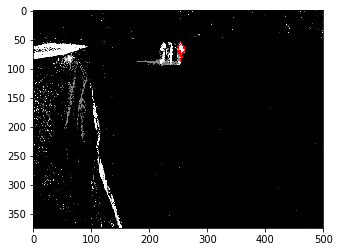

97.5


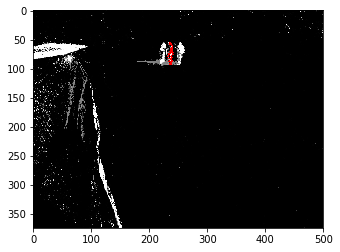

In [274]:
class Box:
    def __init__(self, x_min, y_min, x_max, y_max):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max

        
def filter_ratio(box, ratio_min, ratio_max, disp=False):
    width = box.x_max - box.x_min
    height = box.y_max - box.y_min

    # ratio
    ratio = height / width

    if ratio > ratio_min and ratio < ratio_max:
        return box
    else:
        return None

        
def get_contours_human_ratio(im_path, disp=False):
    # Load image and resize witout changing ratio
    im = cv2.imread(im_path)
    height, width = im.shape[:2]
    new_width = 500
    new_height = new_width*height//width
    im = cv2.resize(im,(new_width, new_height), interpolation = cv2.INTER_CUBIC)
    
    # Change to gray and apply both gaussian and threshold filter
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred_im = cv2.GaussianBlur(im_gray, (1, 1), 0)
    ret,thresh = cv2.threshold(blurred_im, 220, 255, 0)
    
    # Compute contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get dimension of main contours
    les_potential_human_box = []
    for cnt in contours:
        # Compute area size
        area = cv2.contourArea(cnt)
        if area > 3:
            # remove overdimension of contours
            cnt_low = cnt[:, 0]
            
            if disp:
                print(area)
                im2 = cv2.drawContours(im.copy(), cnt, -1, (255,0,0), 2)
                disp_image(im2)
    
            # contour width
            x_max = np.max(cnt_low[:, 0])*width//new_width
            x_min = np.min(cnt_low[:, 0])*width//new_width
            # contour height
            y_max = np.max(cnt_low[:, 1])*height//new_height
            y_min = np.min(cnt_low[:, 1])*height//new_height
            
            potential_human_box = filter_ratio(Box(x_min, y_min, x_max, y_max), 1, 5)
            if potential_human_box is not None:
                les_potential_human_box.append(potential_human_box)
            
    return les_potential_human_box
    
    
a = get_contours_human_ratio("back_sub/220.jpg", disp=True)

## Apply boxes to video

In [308]:
def merge_box(les_box):
    # If a box is above another, merge
    to_process_box = les_box.copy()
    les_new_box = []
    while len(to_process_box) > 0:
        box = to_process_box.pop(0)
        # get x domain
        les_box_mate = []
        for box_mate in les_box:
            # If overlap
            if box.x_max > box_mate.x_min and box_mate.x_max > box.x_min:
                les_box_mate.append(box_mate)
                # Remove the soon merged box mate from the list of "to merge" boxes
                try:
                    to_process_box.remove(box_mate)
                except ValueError:
                    pass
        if len(les_box_mate) != 0:
            # Get boundaries
            x_min_mate = min([box_mate.x_min for box_mate in les_box_mate])
            x_max_mate = max([box_mate.x_max for box_mate in les_box_mate])
            y_min_mate = min([box_mate.y_min for box_mate in les_box_mate])
            y_max_mate = max([box_mate.y_max for box_mate in les_box_mate])
            les_new_box.append(Box(x_min_mate, y_min_mate, x_max_mate, y_max_mate))
    
    return les_new_box


def intertia_consistency_box(les_whole_box, max_dist=5):
    print("Checking box inertia and consistancy")
    # looping to check consistency between boxes n and n-1
    # check if their is a box in the n+1 frame near to the box studied in the n frame
    les_whole_box_intertia = []
    for id_les_box in range(0, len(les_whole_box)-1):
        print("#" + str(id_les_box+1) + "/" + str(len(les_whole_box)), end="\r")
        les_box_inertia = []
        # get the study box
        for study_box in les_whole_box[id_les_box]:
            # init les_box list
            # compute center of studied box
            x = (study_box.x_max - study_box.x_min)/2
            y = (study_box.y_max - study_box.y_min)/2
            for target_box in les_whole_box[id_les_box+1]:
                # compute center of targeted box
                x_target = (target_box.x_max - target_box.x_min)/2
                y_target = (target_box.y_max - target_box.y_min)/2
                dist = np.linalg.norm( np.array([x, y]) - np.array([x_target, y_target]) )
                if dist < max_dist:
                    # if own a near n+1 frame box, keep the studied box
                    les_box_inertia.append(study_box)
                    break
        # Store last frame boxes
        les_whole_box_intertia.append(les_box_inertia)
    print("Done" + " "*20)
    return les_whole_box_intertia


def apply_box_to_video(les_im_path, les_im_backsub_path, video_name="apply_box"):
    
    height,width,layers=cv2.imread(les_im_path[0]).shape

    # Create video object
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    video = cv2.VideoWriter(video_name + '.avi', fourcc, fps=25, frameSize=(width,height))
    
    print("Computing boxes: ratio -> merging -> ratio")
    les_whole_box = []
    # Computing background
    for id_im, im_path in enumerate(les_im_path):
        print("#" + str(id_im+1) + "/" + str(len(les_im_path)), end="\r")
        im = cv2.imread(im_path)
        
        # Get box
        les_box = get_contours_human_ratio(les_im_backsub_path[id_im])
        
        # Merge box
        merged_box = merge_box(les_box)
        
        # Get ride of out of ratio boxes
        les_merged_ratio_box = []
        for box in merged_box:
            merged_ratio_box = filter_ratio(box, 1, 5)
            if merged_ratio_box is not None:
                les_merged_ratio_box.append(merged_ratio_box)
        
        les_whole_box.append(les_merged_ratio_box)
    print("Done" + " "*20)
    
    les_whole_box = intertia_consistency_box(les_whole_box.copy())
    
    print("Writing video")
    for id_les_box, les_box in enumerate(les_whole_box):
        print("#" + str(id_les_box+1) + "/" + str(len(les_whole_box)), end="\r")
        # write box into image
        im = cv2.imread(les_im_path[id_les_box])
        for box in les_box:
            cv2.rectangle(
                im, 
                (box.x_min, box.y_min), 
                (box.x_max, box.y_max),
                (255, 0, 0),
                3
            )
        # write image to video
        video.write(im)
    video.release()
    print("Done" + " "*20)
    

In [ ]:
# disp_image(a)

## Tests

In [309]:
class Test:
    def __init__(self):
        self.dataset_path = data_root
        self.dataset_backsub_path = "back_sub"
        self.les_im_path = self.get_dataset_im_path(self.dataset_path)
        self.les_im_backsub_path = self.get_dataset_im_path(self.dataset_backsub_path)
    
    def get_dataset_im_path(self, path):
        """
        Get images path using glob
        :param path: string, dataset folder
        :return les_im_path: list of string, lsit sorted of every .jpg file in the dataset
        """
        les_im_path = glob.glob(path + "/*.jpg")
        les_im_path.sort()
        return les_im_path
    
    def test_hog(self):
        test_im = self.les_im_path[0]
        hog(test_im)
    
    def background_substraction(self):
        background_substraction(
            self.les_im_path, 
            video_name="backgroud_substraction", 
            back_sub_folder=self.dataset_backsub_path
        )
        self.les_im_backsub_path = self.get_dataset_im_path(self.dataset_backsub_path)
        
    def test_apply_box_to_video(self):
        apply_box_to_video(self.les_im_path, self.les_im_backsub_path)

tester = Test()

# tester.background_substraction()
tester.test_apply_box_to_video()

# tester.test_disp_im()
# tester.test_hog()
# tester.background_substraction()

Computing boxes: ratio -> merging -> ratio
Done                    
Checking box inertia and consistancy
Done                    
Writing video
Done                    


## Generate train dataset

In [ ]:
import struct

def read_seq(path):
    
    def read_header(ifile):
        feed = ifile.read(4)
        norpix = ifile.read(24)
        version = struct.unpack('@i', ifile.read(4))
        length = struct.unpack('@i', ifile.read(4))
        assert(length != 1024)
        descr = ifile.read(512)
        params = [struct.unpack('@i', ifile.read(4))[0] for i in range(0,9)]
        fps = struct.unpack('@d', ifile.read(8))
        # skipping the rest
        ifile.read(432)
        image_ext = {100:'raw', 102:'jpg',201:'jpg',1:'png',2:'png'}
        return {'w':params[0],'h':params[1],
                'bdepth':params[2],
                'ext':image_ext[params[5]],
                'format':params[5],
                'size':params[4],
                'true_size':params[8],
                'num_frames':params[6]}
    
    ifile = open(path, 'rb')
    params = read_header(ifile)
    bytes = open(path, 'rb').read()

    # this is freaking magic, but it works
    extra = 8
    s = 1024
    seek = [0]*(params['num_frames']+1)
    seek[0] = 1024
    
    images = []
    
    for i in range(0, params['num_frames']-1):
        tmp = struct.unpack_from('@I', bytes[s:s+4])[0]
        s = seek[i] + tmp + extra
        if i == 0:
            val = struct.unpack_from('@B', bytes[s:s+1])[0]
            if val != 0:
                s -= 4
            else:
                extra += 8
                s += 8
        seek[i+1] = s
        nbytes = struct.unpack_from('@i', bytes[s:s+4])[0]
        I = bytes[s+4:s+nbytes]
        
        tmp_file = '/tmp/img%d.jpg' % i
        open(tmp_file, 'wb+').write(I)
        
        img = cv2.imread(tmp_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

a = read_seq("dataset/set00/V000.seq")[200]

## Interface function

In [ ]:
def pedestrians(data_root, _W, _H, _N):
    ''' Return a list of bounding boxes in the format frame, bb_id, x,y,dx,dy '''
    return [[1,1,617,128,20,50]]

## N.Evaluation

In [ ]:
def format_id(frame):
    assert _N >= frame
    return '{:03d}'.format(frame)


def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return cv2.imread(os.path.join(root,format_id(frame)+'.jpg'), cv2.IMREAD_UNCHANGED)
    

def read_gt(filename):
    """Read gt and create list of bb-s"""
    assert os.path.exists(filename)
    with open(filename, 'r') as file:
        lines = file.readlines()
    # truncate data (last columns are not needed)
    return [list(map(lambda x: int(x), line.split(',')[:6])) for line in lines]


def annotations_for_frame(solution, frame):
    assert _N >= frame
    return [bb for bb in solution if int(bb[0])==int(frame)]


def evaluate_solution(gt, solution, N):
    """Caclulate evaluation metric"""
    score = []
    #for frame in [300]:
    for frame in range(1, N):
        bbs_sol = annotations_for_frame(solution, frame)
        bbs_gt = annotations_for_frame(gt, frame)
        black_sol = np.zeros((_H, _W))
        black_gt = np.zeros((_H, _W))
        for bb in bbs_sol:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_sol, (x, y), (x+dx, y+dy), (255), -1)
        for bb in bbs_gt:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_gt, (x, y), (x+dx, y+dy), (255), -1)
        # intersection over union
        intersection = black_sol * black_gt
        intersection[intersection > 0.5] = 1
        union = black_sol + black_gt
        union[union > 0.5] = 1
        if not union.any():
            continue
        score.append(intersection.sum()/union.sum())
        
        
    return np.asarray(score).mean()
    

def show_annotation(solution, frame):
    assert _N >= frame
    im = read_frame(data_root, frame)
    bbs = annotations_for_frame(solution, frame)
    for bb in bbs:
        x, y = bb[2:4]
        dx, dy = bb[4:6]
        cv2.rectangle(im, (x, y), (x+dx, y+dy), (0,255,0), 10)
    plt.imshow(im)
    plt.title('Annotations for frame {}.'.format(frame))
    plt.show()
    return


SCORING = True
if SCORING:
    gt = read_gt(gt_path)

    show_annotation(gt, 300)

    print('A perfect score... {}'.format(evaluate_solution(gt, gt, _N)))

    # your solution will be tested simply by changing the dataset
    # and changing the module, i.e., the following has to work 
    # with simply using your module 
    sol = pedestrians(data_root, _W, _H, _N)
    print('A great score! {}'.format(evaluate_solution(sol, gt, _N)))

